In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule, PyroParam
from pyro.infer import autoguide, SVI, Trace_ELBO

pyro.enable_validation(True)

from scipy.stats import beta, norm

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


## Coin toss problem
https://pyro.ai/examples/svi_part_i.html#A-simple-example

In [3]:
# create some data with 7 observed heads and 3 observed tails
data = []

for _ in range(7):
    data.append(torch.tensor(1.0))
for _ in range(3):
    data.append(torch.tensor(0.0))

Reimplementing the coin toss example as a PyroModule.

In [4]:
class CoinFlipModule(PyroModule):
    
    def __init__(self, data):
        super().__init__()
        
        # define the hyperparameters that control the beta prior
        self.alpha0 = torch.tensor(10.0)
        self.beta0 = torch.tensor(10.0)
        
        self.data = data
        
    @pyro.nn.pyro_method
    def model(self):
        # sample f from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        # loop over the observed data
        for i in range(len(data)):
            # observe datapoint i using the bernoulli
            # likelihood Bernoulli(f)
            pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    
    @pyro.nn.pyro_method     
    def guide(self):
        alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
        beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)

        # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
        pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [5]:
pyro.clear_param_store()
coinFlip = CoinFlipModule(data)

In [6]:
opt = pyro.optim.Adam({'lr': 0.01})
loss = Trace_ELBO()
svi = SVI(coinFlip.model, coinFlip.guide, opt, loss)

losses = []
alphas = []
betas = []
for _ in range(2000):
    losses.append(svi.step())
    alphas.append(pyro.param("alpha_q").item())
    betas.append(pyro.param("beta_q").item())

### Visualising training

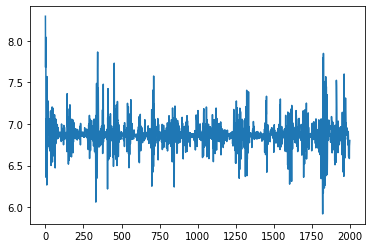

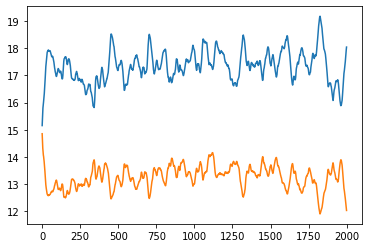

In [7]:
plt.plot(losses);

plt.figure()
plt.plot(alphas)
plt.plot(betas)

In [8]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("Based on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

Based on the data and our prior belief, the fairness of the coin is 0.600 +- 0.088


### Visual interpretation of the results

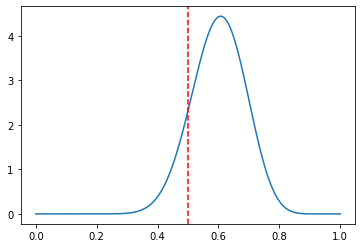

In [9]:
x = np.linspace(0, 1, 1000)
dist_ = beta(alpha_q, beta_q)
plt.plot(x, dist_.pdf(x))
plt.axvline(x=0.5, color='r', linestyle='--');

### Predictive distribution

Using predictive distribution sample coin flips, calculate mean and standard deviation and compare agains the inferred values.

In [10]:
predictive = pyro.infer.Predictive(coinFlip.model, guide=coinFlip.guide, num_samples=1000, return_sites=('latent_fairness',))
predict_fairness = predictive()

In [11]:
print(predict_fairness['latent_fairness'].detach().numpy().mean(),
    predict_fairness['latent_fairness'].detach().numpy().std())

0.59839845 0.08926226


# Autoguide

Now I am trying to see whether I can use autoguide instead of specifying guide explicitly.

In [12]:
class CoinFlipModuleAuto(PyroModule):
    
    def __init__(self, data):
        super().__init__()
        
        # define the hyperparameters that control the beta prior
        self.alpha0 = torch.tensor(10.0)
        self.beta0 = torch.tensor(10.0)
        
        self.data = data
        
    @pyro.nn.pyro_method
    def model(self):
        # sample f from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        # loop over the observed data
        for i in range(len(data)):
            # observe datapoint i using the bernoulli
            # likelihood Bernoulli(f)
            pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])       
    

In [13]:
pyro.clear_param_store()
coinFlip_auto = CoinFlipModuleAuto(data)
coinFlip_guide = autoguide.AutoMultivariateNormal(coinFlip_auto.model)

In [14]:
opt = pyro.optim.Adam({'lr': 0.001})
loss = Trace_ELBO()
svi = SVI(coinFlip_auto.model, coinFlip_guide, opt, loss)

losses = []
for _ in range(2000):
    losses.append(svi.step())

### Visualising training

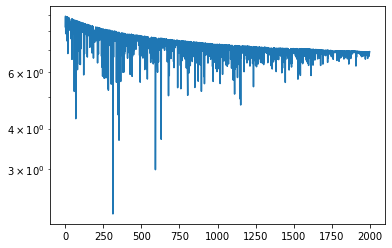

In [15]:
plt.semilogy(losses);

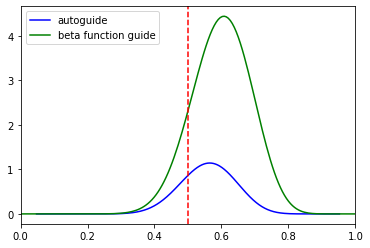

In [16]:
ps = pyro.get_param_store()

# These values are in unconstrained domained, thus a sigmoid needs to be used to bring them to the [0, 1] domain.
mean = (ps.get_param('AutoMultivariateNormal.loc')).detach().numpy()
std = (ps.get_param('AutoMultivariateNormal.scale_tril')).detach().numpy()
x = np.linspace(-3, 3, 1002)[1:-1]
dist_ = norm(mean, std)
plt.plot(nn.Sigmoid()(torch.tensor(x)).detach(), dist_.pdf(torch.tensor(x)).squeeze(), color='b', label="autoguide")
plt.plot(x, beta(alpha_q, beta_q).pdf(x), color='g', label="beta function guide")
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlim(0,1)
plt.legend();

### Predictive distribution

Using predictive distribution sample coin flips, calculate mean and standard deviation and compare agains the inferred values.

In [17]:
predictive = pyro.infer.Predictive(coinFlip_auto.model, guide=coinFlip_guide, num_samples=1000, return_sites=('latent_fairness',))
predict_fairness = predictive()

In [18]:
print(predict_fairness['latent_fairness'].detach().numpy().mean(),
    predict_fairness['latent_fairness'].detach().numpy().std())

0.56341285 0.08214897


# Custom guide - normal distribution

In [19]:
class CoinFlipModuleNorm(PyroModule):
    
    def __init__(self, data):
        super().__init__()
        
        # define the hyperparameters that control the beta prior
        self.mu0 = torch.tensor(0.5)
        self.std0 = torch.tensor(0.1)
        
        self.data = data
        
    @pyro.nn.pyro_method
    def model(self):
        # sample f from the beta prior
        f = pyro.sample("latent_fairness", dist.Normal(self.mu0, self.std0))
        # loop over the observed data
        for i in range(len(data)):
            # observe datapoint i using the bernoulli
            pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    
    @pyro.nn.pyro_method     
    def guide(self):
        
        mu_g = pyro.param("mu_g", torch.tensor(0.5), constraint=constraints.interval(0.0, 1.0))
        std_g = pyro.param("std_g", torch.tensor(0.1), constraint=constraints.positive)

        # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
        pyro.sample("latent_fairness", dist.Normal(mu_g, std_g))

In [20]:
pyro.clear_param_store()
coinFlip_normal = CoinFlipModuleNorm(data)

opt = pyro.optim.Adam({'lr': 0.001})
loss = Trace_ELBO()
svi = SVI(coinFlip_normal.model, coinFlip_normal.guide, opt, loss)

losses = []
for _ in range(2000):
    losses.append(svi.step())

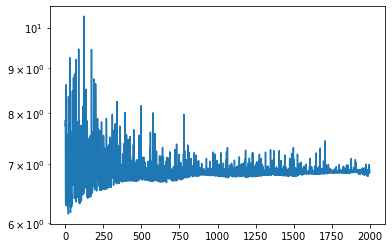

In [21]:
plt.semilogy(losses);

In [22]:
ps = pyro.get_param_store()
mean = (ps.get_param('mu_g')).detach().numpy()
std = (ps.get_param('std_g')).detach().numpy()

print("mean: ", mean, "std: ", std)

mean:  0.5550759 std:  0.08386096


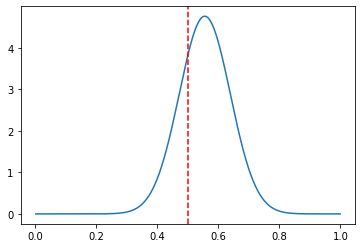

In [23]:
x = np.linspace(0, 1, 1002)[1:-1]
dist_ = norm(mean, std)
plt.plot(x, dist_.pdf(x))
plt.axvline(x=0.5, color='r', linestyle='--')